In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM

### Load data

In [2]:
# Load datacube

fp_data = "/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_200kV_ca0p51_cl300_30x30_5nmstep_exp0p1.dm4"
dc = py4DSTEM.file.io.read(fp_data)
dc.set_scan_shape(30,30)
dc.data = np.roll(dc.data,axis=1,shift=-2)

/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_200kV_ca0p51_cl300_30x30_5nmstep_exp0p1.dm4 is not a py4DSTEM file.
Reading with hyperspy...


In [3]:
# Read processing file

fp_processing = "/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/processing_0p51mrad.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    average_DP                          DiffractionSlice    
   1    braggvectormap_shiftcorrected       DiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffractionshifts                   RealSlice           
   5    ellipse_params                      PointList           
   6    braggpeaks_shiftcorrected           PointListArray      
   7    braggpeaks_uncorrected              PointListArray      


In [4]:
# Get processing data

aveDP = browser.get_dataobject('average_DP').data
diffractionshifts = browser.get_dataobject('diffractionshifts')
ellipse_params = browser.get_dataobject('ellipse_params')
browser.close()

ellipse_params1 = (ellipse_params.data['x0'][0],ellipse_params.data['y0'][0], ellipse_params.data['A'][0], ellipse_params.data['B'][0], ellipse_params.data['phi'][0])
ellipse_params2 = (ellipse_params.data['x0'][1],ellipse_params.data['y0'][1], ellipse_params.data['A'][1], ellipse_params.data['B'][1], ellipse_params.data['phi'][1])
ellipse_params3 = (ellipse_params.data['x0'][2],ellipse_params.data['y0'][2], ellipse_params.data['A'][2], ellipse_params.data['B'][2], ellipse_params.data['phi'][2])

### Polar-elliptical transform

In [5]:
from py4DSTEM.process.utils import cartesianDataAr_to_polarEllipticalDataAr

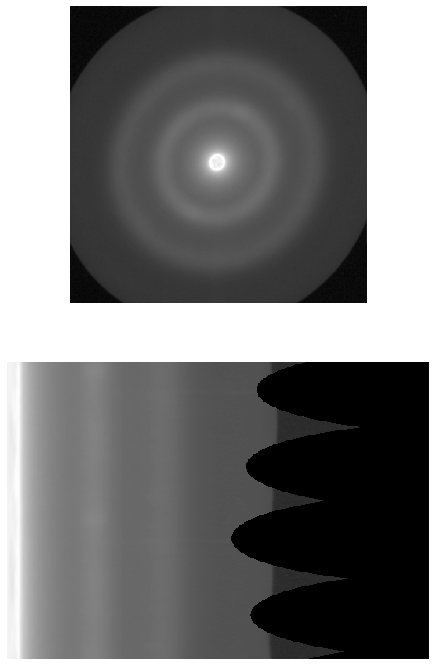

In [6]:
# Polar-elliptical transform

power = 0.2

polarEllipticalData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=aveDP,
                                    params=ellipse_params3,
                                    dr=1,
                                    r_range=512,
                                    dtheta=np.radians(1),
                                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(aveDP**power)
ax2.matshow(polarEllipticalData.data**power)
ax1.axis('off')
ax2.axis('off')
plt.show()

In [33]:
# All polar-elliptical transforms

polar_elliptical_transforms = np.ma.array(data=np.zeros((dc.R_Nx,dc.R_Ny,polarEllipticalData.shape[0],polarEllipticalData.shape[1])),
                                          mask=np.zeros((dc.R_Nx,dc.R_Ny,polarEllipticalData.shape[0],polarEllipticalData.shape[1])))
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        x0 = ellipse_params3[0] + diffractionshifts.slices['x'][Rx,Ry]
        y0 = ellipse_params3[1] + diffractionshifts.slices['y'][Rx,Ry]
        A,B,phi = ellipse_params3[2:]
        polar_elliptical_transform,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=dc.data[Rx,Ry,:,:],
                                    params=(x0,y0,A,B,phi),
                                    dr=1,
                                    r_range=512,
                                    dtheta=np.radians(1),
                                    mask=None
        )
        polar_elliptical_transforms.data[Rx,Ry,:,:] = polar_elliptical_transform.data
        polar_elliptical_transforms.mask[Rx,Ry,:,:] = polar_elliptical_transform.mask

In [34]:
ave_im = np.average(dc.data,axis=(2,3))

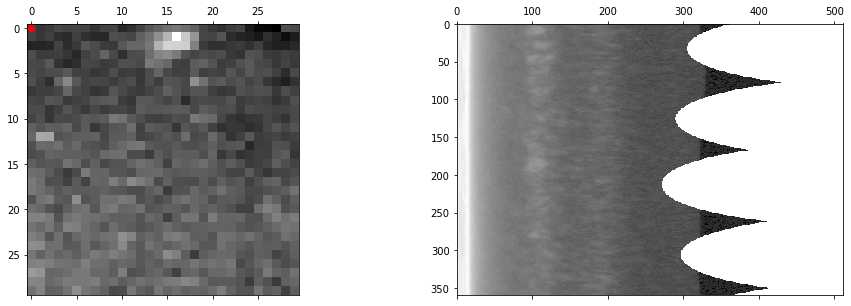

In [35]:
Rx,Ry = 0,0
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[Rx,Ry,:,:]**power)
plt.show()

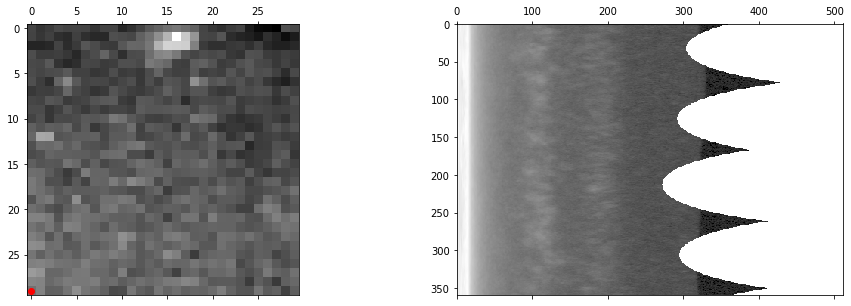

In [36]:
Rx,Ry = 29,0
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[Rx,Ry,:,:]**power)
plt.show()

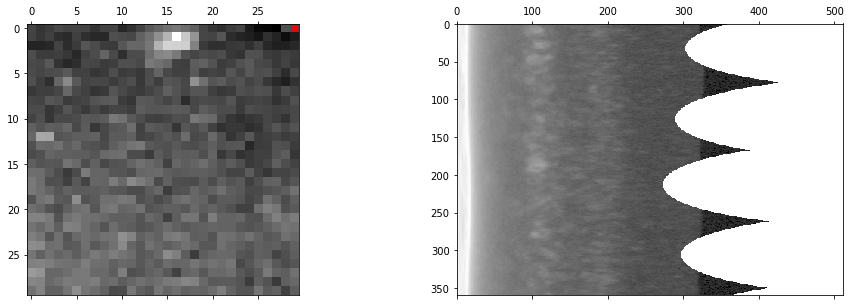

In [37]:
Rx,Ry = 0,29
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[Rx,Ry,:,:]**power)
plt.show()

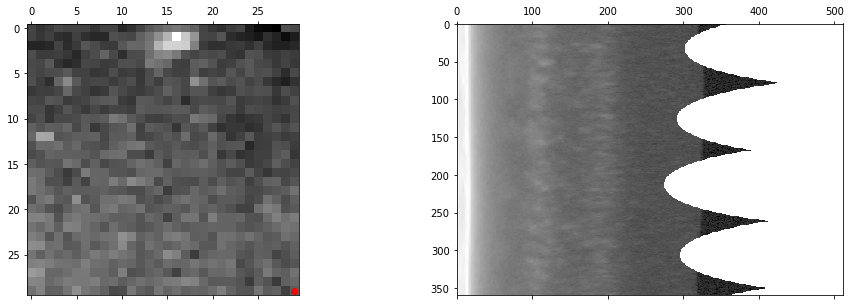

In [38]:
Rx,Ry = 29,29
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[Rx,Ry,:,:]**power)
plt.show()

### FEM

In [39]:
_,_,Ntheta,Nr = polar_elliptical_transforms.shape

In [41]:
means = np.mean(polar_elliptical_transforms,axis=2)
stds = np.std(polar_elliptical_transforms,axis=2)
fem_map = stds/means

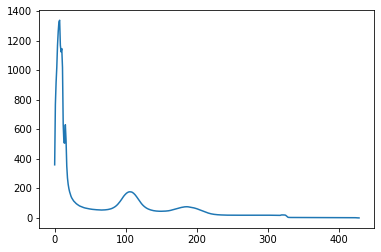

In [47]:
aveMean = np.average(means,axis=(0,1))
aveStd = np.average(stds,axis=(0,1))
aveFEM = np.average(fem_map,axis=(0,1))

fig,ax = plt.subplots()
ax.plot(np.arange(Nr),aveStd)
plt.show()

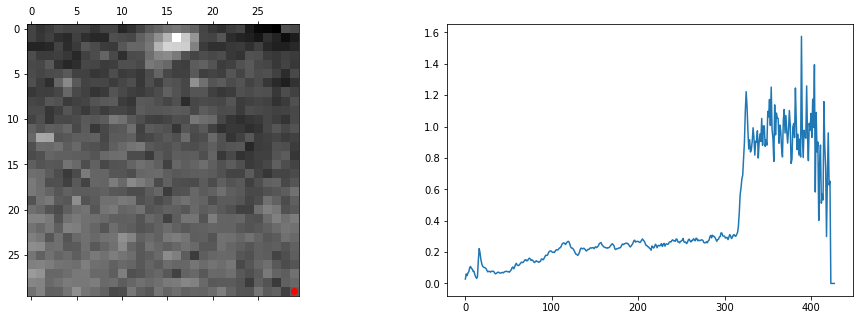

In [57]:
Rx,Ry = 29,29
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.plot(np.arange(Nr),stds[Rx,Ry,:]/means[Rx,Ry,:])
plt.show()